# TESS Atlas fit for TOI 144

**Version: 0.1.0**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 144.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-144.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.0/toi-144.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.0/toi-144.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 144

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 144 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

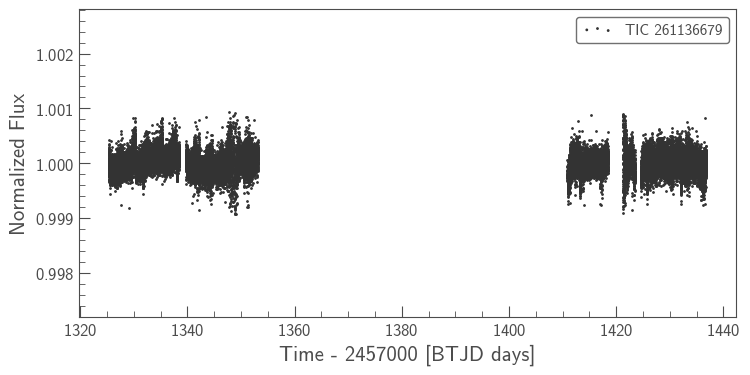

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all()
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")

# tpf_collection[0].to_lightcurve(aperture_mask="pipeline").plot()
# assert 0
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])    
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
lc = lc.remove_outliers()
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] *= 1000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -15196.774712879796 -> 5168.679727031928


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: 3869.319814410343 -> 14380.502221501813


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: 14380.502221501813 -> 14440.107259161088


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: 14440.107259161088 -> 14440.107432054534


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 14440.107432054534 -> 14529.867626623522


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: 14529.867626623522 -> 14534.110510665561


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 14534.110510665561 -> 14542.617274659788


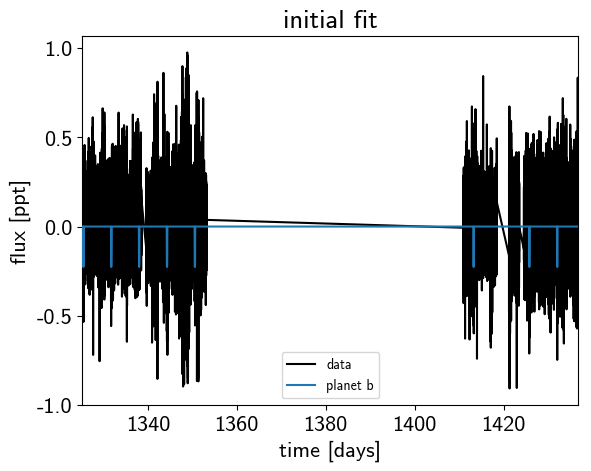

In [7]:
model = build_model(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:07, 12.21draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:25,  3.61draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:21,  4.27draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:40,  2.22draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:03<00:37,  2.40draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:40,  2.19draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:04<00:46,  1.87draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:40,  2.15draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:05<00:49,  1.72draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:06<00:44,  1.86draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:06<00:41,  1.97draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:07<00:42,  1.92draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:08<00:53,  1.50draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:09<00:50,  1.54draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:10<00:47,  1.62draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:10<00:41,  1.84draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:11<00:49,  1.52draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:12<00:42,  1.70draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:12<00:37,  1.93draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:13<00:35,  1.98draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:13<00:29,  2.37draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:14<00:34,  1.97draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:15<00:33,  1.98draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:15<00:34,  1.90draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:16<00:40,  1.59draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:17<00:35,  1.79draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:17<00:37,  1.64draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:18<00:29,  2.07draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:19<00:37,  1.59draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:19<00:30,  1.96draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:20<00:35,  1.62draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:20<00:33,  1.69draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:21<00:33,  1.68draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:21<00:31,  1.74draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:22<00:29,  1.83draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:23<00:34,  1.52draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:24<00:30,  1.69draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:24<00:28,  1.76draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:25<00:25,  1.90draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:25<00:29,  1.64draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:26<00:26,  1.75draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:27<00:25,  1.77draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:27<00:21,  2.09draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:28<00:25,  1.71draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:28<00:20,  2.08draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:29<00:21,  1.93draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:30<00:24,  1.65draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:31<00:22,  1.73draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:31<00:19,  1.85draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:32<00:18,  2.00draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:32<00:20,  1.67draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:33<00:18,  1.83draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:34<00:15,  2.07draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:34<00:15,  2.05draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:35<00:18,  1.66draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:36<00:15,  1.82draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:37<00:16,  1.61draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:38<00:14,  1.74draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:38<00:14,  1.67draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:39<00:12,  1.82draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:40<00:12,  1.72draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:40<00:09,  2.17draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:41<00:10,  1.76draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:41<00:10,  1.70draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:43<00:14,  1.21draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:44<00:15,  1.06draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:44<00:12,  1.23draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:45<00:10,  1.28draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:46<00:12,  1.07draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:48<00:13,  1.12s/draws]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:50<00:13,  1.27s/draws]

Sampling 2 chains:  90%|█████████ | 94/104 [00:51<00:12,  1.28s/draws]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:53<00:12,  1.38s/draws]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:54<00:11,  1.42s/draws]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:55<00:09,  1.36s/draws]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:57<00:08,  1.36s/draws]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:58<00:06,  1.38s/draws]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:59<00:05,  1.36s/draws]

Sampling 2 chains:  97%|█████████▋| 101/104 [01:01<00:03,  1.30s/draws]

Sampling 2 chains:  98%|█████████▊| 102/104 [01:02<00:02,  1.32s/draws]

Sampling 2 chains:  99%|█████████▉| 103/104 [01:03<00:01,  1.30s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:09<00:00,  2.62s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:07, 11.95draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:15,  5.83draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:22,  4.02draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:31,  2.86draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:03<00:40,  2.20draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:31,  2.76draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:33,  2.57draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:35,  2.45draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:44,  1.90draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:06<00:46,  1.79draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:07<00:43,  1.87draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:07<00:42,  1.87draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:07<00:38,  2.08draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:08<00:48,  1.60draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:10<00:46,  1.63draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:10<00:34,  2.15draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:11<00:41,  1.77draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:11<00:38,  1.91draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:11<00:34,  2.10draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:12<00:42,  1.69draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:13<00:37,  1.83draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:13<00:32,  2.09draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:14<00:32,  2.06draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:15<00:40,  1.65draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:15<00:30,  2.15draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:16<00:35,  1.80draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:16<00:31,  2.03draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:17<00:31,  1.96draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:17<00:26,  2.33draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:18<00:37,  1.61draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:18<00:29,  1.94draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:19<00:34,  1.65draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:20<00:29,  1.90draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:20<00:34,  1.62draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:21<00:28,  1.89draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:22<00:35,  1.50draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:23<00:30,  1.65draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:23<00:28,  1.75draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:24<00:25,  1.94draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:24<00:22,  2.13draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:24<00:21,  2.15draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:25<00:20,  2.29draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:26<00:24,  1.82draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:26<00:20,  2.10draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:26<00:20,  2.10draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:27<00:23,  1.78draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:28<00:20,  1.95draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:28<00:18,  2.06draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:29<00:17,  2.14draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:30<00:22,  1.68draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:30<00:16,  2.20draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:30<00:18,  1.91draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:31<00:20,  1.63draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:32<00:17,  1.82draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:33<00:17,  1.73draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:33<00:12,  2.29draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:34<00:16,  1.72draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:34<00:12,  2.24draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:35<00:13,  1.86draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:35<00:12,  2.06draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:36<00:11,  2.08draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:36<00:09,  2.20draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:37<00:07,  2.71draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:37<00:07,  2.64draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:37<00:07,  2.50draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:38<00:05,  3.11draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:38<00:06,  2.56draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:38<00:05,  2.77draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:39<00:07,  1.91draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:40<00:09,  1.41draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:42<00:11,  1.18draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:42<00:08,  1.48draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:43<00:08,  1.25draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:44<00:09,  1.06draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:45<00:09,  1.00s/draws]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:47<00:08,  1.05s/draws]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:48<00:08,  1.24s/draws]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:50<00:08,  1.34s/draws]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:51<00:06,  1.32s/draws]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:52<00:05,  1.29s/draws]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:53<00:03,  1.24s/draws]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:55<00:02,  1.31s/draws]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:56<00:01,  1.39s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:02<00:00,  2.59s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:01<04:38,  1.37s/draws]

Sampling 2 chains:   1%|          | 2/204 [00:01<03:27,  1.03s/draws]

Sampling 2 chains:   2%|▏         | 4/204 [00:02<02:37,  1.27draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:02<02:21,  1.41draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:02<01:51,  1.78draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:03<01:32,  2.12draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:03<01:57,  1.66draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:04<02:04,  1.57draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:05<02:03,  1.57draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:05<01:56,  1.65draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:06<01:50,  1.74draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:06<01:23,  2.30draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:06<01:25,  2.21draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:07<01:18,  2.41draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:08<01:35,  1.96draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:08<01:21,  2.28draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:08<01:12,  2.56draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:09<01:33,  1.97draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:10<01:25,  2.13draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:10<01:17,  2.33draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:11<01:17,  2.33draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:11<01:29,  2.00draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:12<01:24,  2.09draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:12<01:10,  2.50draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:13<01:02,  2.79draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:13<00:59,  2.93draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:13<00:55,  3.10draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:14<01:10,  2.43draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:15<01:20,  2.12draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:15<01:06,  2.54draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:16<01:29,  1.87draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:16<01:06,  2.50draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:16<00:48,  3.36draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:16<00:44,  3.68draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:17<00:45,  3.58draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:18<01:03,  2.51draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:18<00:48,  3.23draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:18<01:00,  2.57draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:19<01:10,  2.20draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:19<00:56,  2.75draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:20<00:57,  2.64draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:20<00:46,  3.20draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:21<01:06,  2.22draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:21<00:54,  2.73draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:21<00:43,  3.35draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:22<00:48,  3.00draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:22<00:38,  3.72draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:23<00:54,  2.64draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:24<01:05,  2.17draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:24<00:50,  2.80draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:25<01:10,  2.00draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:25<00:56,  2.47draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:25<01:03,  2.18draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:26<01:06,  2.07draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:26<00:55,  2.46draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:27<00:56,  2.37draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:27<00:47,  2.78draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:28<00:41,  3.19draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:28<00:58,  2.22draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:29<00:45,  2.86draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:29<00:56,  2.27draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:30<01:07,  1.87draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:30<00:53,  2.34draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:31<00:52,  2.34draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:31<00:48,  2.53draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:31<00:47,  2.55draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:32<00:46,  2.56draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:32<00:36,  3.24draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:33<00:48,  2.46draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:33<00:47,  2.44draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:34<00:47,  2.45draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:34<00:56,  2.03draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:35<00:46,  2.43draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:36<00:59,  1.89draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:36<00:45,  2.44draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:36<00:52,  2.11draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:37<00:54,  2.02draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:37<00:40,  2.66draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:37<00:43,  2.47draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:38<00:44,  2.36draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:38<00:48,  2.18draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:39<00:40,  2.59draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:40<00:52,  1.97draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:40<00:43,  2.34draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:40<00:32,  3.07draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:41<00:45,  2.16draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:42<00:39,  2.43draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:42<00:31,  3.06draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:42<00:39,  2.40draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:42<00:31,  2.98draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:43<00:41,  2.20draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:43<00:34,  2.65draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:44<00:34,  2.62draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:44<00:31,  2.76draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:45<00:32,  2.67draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:45<00:24,  3.39draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:46<00:26,  3.11draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:47<00:30,  2.66draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:47<00:30,  2.61draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:48<00:40,  1.96draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:49<00:36,  2.11draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:49<00:36,  2.07draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:50<00:31,  2.41draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:50<00:26,  2.77draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:50<00:30,  2.36draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:51<00:33,  2.13draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:51<00:28,  2.48draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:52<00:36,  1.91draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:53<00:33,  2.06draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:53<00:29,  2.26draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:54<00:30,  2.20draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:54<00:28,  2.27draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:54<00:23,  2.73draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:55<00:27,  2.30draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:55<00:31,  1.94draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:56<00:29,  2.06draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:56<00:23,  2.52draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:57<00:22,  2.56draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:58<00:20,  2.78draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:58<00:16,  3.21draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:58<00:17,  2.97draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:59<00:23,  2.26draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:59<00:18,  2.74draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [01:00<00:24,  2.04draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [01:00<00:21,  2.31draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [01:01<00:21,  2.28draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [01:01<00:17,  2.76draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [01:02<00:20,  2.25draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [01:02<00:19,  2.29draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [01:03<00:14,  2.96draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:03<00:16,  2.46draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [01:04<00:18,  2.21draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:04<00:14,  2.64draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [01:05<00:17,  2.13draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:05<00:14,  2.64draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [01:05<00:12,  2.94draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [01:05<00:10,  3.27draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [01:06<00:09,  3.38draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:06<00:07,  4.08draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:06<00:07,  4.26draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [01:07<00:12,  2.50draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:07<00:09,  3.00draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [01:08<00:11,  2.29draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:10<00:17,  1.47draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [01:11<00:20,  1.24draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:12<00:21,  1.13draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:12<00:17,  1.30draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:13<00:15,  1.43draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [01:13<00:11,  1.89draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:14<00:13,  1.50draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:15<00:11,  1.62draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:16<00:13,  1.33draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:17<00:10,  1.46draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [01:17<00:08,  1.75draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:18<00:11,  1.24draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [01:19<00:11,  1.11draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:21<00:11,  1.04draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [01:22<00:10,  1.00draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:22<00:08,  1.16draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:22<00:06,  1.49draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:23<00:04,  1.86draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:24<00:04,  1.51draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:25<00:05,  1.12draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:26<00:04,  1.03draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:27<00:04,  1.02s/draws]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:28<00:03,  1.06s/draws]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:29<00:01,  1.05draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:30<00:01,  1.00s/draws]

Sampling 2 chains: 100%|██████████| 204/204 [01:31<00:00,  1.06s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/404 [00:00<00:31, 12.87draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:33, 11.85draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:41,  9.59draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:45,  8.73draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:01<00:37, 10.54draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:01<00:44,  8.81draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:01<00:38,  9.98draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:01<00:39,  9.78draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:01<00:32, 11.95draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:02<00:27, 13.81draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:02<00:25, 14.73draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:02<00:22, 16.98draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:02<00:24, 15.43draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:02<00:26, 13.99draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:02<00:23, 15.50draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:02<00:24, 15.15draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:02<00:20, 17.73draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:03<00:17, 20.38draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:03<00:15, 23.50draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:03<00:17, 20.09draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:03<00:18, 19.26draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:03<00:16, 20.42draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:03<00:16, 20.12draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:04<00:17, 19.26draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:04<00:16, 20.37draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:04<00:15, 22.01draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:04<00:17, 19.14draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:04<00:15, 21.61draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:04<00:14, 22.81draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:04<00:13, 23.64draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:05<00:13, 23.55draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:05<00:12, 24.28draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:05<00:14, 22.02draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:05<00:13, 22.81draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:05<00:14, 21.68draws/s]

Sampling 2 chains:  26%|██▌       | 104/404 [00:05<00:11, 25.10draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:05<00:12, 24.64draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:05<00:10, 26.81draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:06<00:10, 28.10draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:06<00:11, 25.15draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:06<00:10, 25.96draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:06<00:10, 25.66draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:06<00:11, 24.78draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:06<00:10, 25.92draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:06<00:10, 26.32draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:07<00:09, 26.41draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:07<00:09, 25.86draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:07<00:09, 26.10draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:07<00:10, 24.81draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:07<00:10, 24.68draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:07<00:09, 24.68draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:07<00:08, 26.86draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:08<00:08, 28.58draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:08<00:10, 21.88draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:08<00:10, 21.40draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:08<00:09, 23.29draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:08<00:08, 25.94draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:08<00:08, 25.52draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:08<00:07, 29.10draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:09<00:07, 28.37draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:09<00:09, 22.78draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:09<00:07, 26.43draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:09<00:07, 28.01draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:09<00:06, 27.70draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:09<00:08, 21.25draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:10<00:09, 20.47draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:10<00:08, 21.95draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:10<00:09, 18.61draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:10<00:09, 18.08draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:10<00:08, 21.48draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:10<00:07, 22.97draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:11<00:06, 25.80draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:11<00:06, 25.97draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:11<00:10, 15.58draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [00:11<00:09, 15.76draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:11<00:08, 17.68draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:11<00:08, 18.10draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:12<00:07, 18.84draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:12<00:07, 19.51draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:12<00:08, 17.60draws/s]

Sampling 2 chains:  66%|██████▌   | 267/404 [00:12<00:06, 20.41draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:12<00:06, 19.33draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:12<00:06, 20.40draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:13<00:05, 21.18draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:13<00:05, 22.28draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:13<00:04, 24.11draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:13<00:04, 23.75draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:13<00:04, 23.06draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:13<00:04, 25.19draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:13<00:05, 18.98draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:14<00:05, 19.58draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:14<00:05, 19.50draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:14<00:05, 18.96draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:14<00:04, 22.76draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:14<00:03, 23.70draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:14<00:03, 22.92draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:14<00:03, 22.89draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:15<00:03, 24.22draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:15<00:02, 27.70draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:15<00:02, 25.29draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [00:15<00:02, 28.42draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:15<00:02, 30.28draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:15<00:01, 30.17draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:16<00:02, 19.63draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [00:16<00:02, 21.34draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:16<00:02, 20.93draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [00:16<00:02, 20.75draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:16<00:01, 23.09draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:16<00:01, 22.05draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:16<00:01, 20.11draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [00:17<00:01, 21.53draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [00:17<00:01, 17.93draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:17<00:01, 18.62draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:17<00:01, 20.37draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:17<00:01, 14.81draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:18<00:01, 12.31draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:18<00:01, 10.34draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:18<00:01, 11.82draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:18<00:00, 11.28draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:18<00:00, 11.23draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:19<00:00, 10.90draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:19<00:00, 11.27draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:19<00:00, 11.19draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:19<00:00, 10.90draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:19<00:00, 20.41draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:34, 23.01draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:31, 25.63draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:00<00:31, 25.10draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:27, 28.88draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:00<00:25, 31.15draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:00<00:22, 34.25draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:00<00:19, 39.76draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:01<00:17, 43.41draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:01<00:18, 41.46draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:01<00:19, 39.49draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:01<00:18, 40.60draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:01<00:15, 47.90draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:01<00:16, 43.22draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:01<00:15, 46.69draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:01<00:14, 49.01draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:01<00:14, 50.53draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:02<00:15, 45.66draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:02<00:15, 46.69draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:02<00:14, 47.32draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:02<00:13, 49.54draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:02<00:17, 39.29draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:02<00:16, 41.72draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:02<00:16, 41.34draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:03<00:14, 46.19draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:03<00:16, 40.93draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:03<00:16, 39.75draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:03<00:17, 38.28draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:03<00:15, 40.92draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:03<00:16, 39.27draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:03<00:16, 39.85draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:03<00:15, 41.17draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:04<00:14, 42.84draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:04<00:15, 39.85draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:04<00:16, 37.97draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:04<00:17, 34.44draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:04<00:16, 37.23draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:04<00:18, 33.64draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [00:04<00:16, 36.31draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:04<00:14, 40.36draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:05<00:13, 42.37draws/s]

Sampling 2 chains:  27%|██▋       | 219/804 [00:05<00:14, 39.07draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:05<00:14, 40.78draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:05<00:13, 44.03draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:05<00:12, 43.83draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [00:05<00:12, 44.38draws/s]

Sampling 2 chains:  30%|███       | 245/804 [00:05<00:13, 40.79draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:06<00:15, 35.26draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:06<00:14, 37.93draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:06<00:14, 38.14draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:06<00:14, 37.88draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:06<00:15, 34.49draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:06<00:14, 35.89draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:06<00:15, 34.83draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [00:06<00:14, 35.34draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [00:06<00:13, 39.36draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [00:07<00:12, 41.60draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:07<00:12, 40.15draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:07<00:11, 45.47draws/s]

Sampling 2 chains:  39%|███▊      | 310/804 [00:07<00:09, 49.84draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:07<00:09, 52.56draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:07<00:08, 54.33draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:07<00:08, 54.10draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:07<00:08, 53.64draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:07<00:07, 57.67draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:08<00:08, 54.91draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [00:08<00:08, 54.52draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:08<00:08, 50.61draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:08<00:07, 54.74draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:08<00:07, 58.21draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [00:08<00:07, 56.87draws/s]

Sampling 2 chains:  48%|████▊     | 388/804 [00:08<00:08, 50.14draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [00:08<00:08, 50.73draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [00:09<00:08, 47.36draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:09<00:08, 46.68draws/s]

Sampling 2 chains:  51%|█████     | 412/804 [00:09<00:07, 51.61draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [00:09<00:07, 53.71draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:09<00:06, 58.19draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:09<00:06, 60.80draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [00:09<00:05, 62.02draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:09<00:06, 54.07draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:10<00:05, 58.49draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:10<00:05, 59.25draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:10<00:05, 60.99draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:10<00:05, 58.64draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [00:10<00:05, 63.37draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:10<00:04, 62.94draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [00:10<00:04, 64.04draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:10<00:04, 62.36draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:11<00:05, 50.16draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [00:11<00:05, 56.00draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [00:11<00:04, 56.34draws/s]

Sampling 2 chains:  67%|██████▋   | 537/804 [00:11<00:04, 54.68draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [00:11<00:05, 51.75draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:11<00:04, 54.50draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:11<00:04, 56.53draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [00:11<00:04, 58.81draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:11<00:03, 60.97draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:12<00:04, 55.46draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [00:12<00:04, 50.30draws/s]

Sampling 2 chains:  73%|███████▎  | 590/804 [00:12<00:04, 47.10draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [00:12<00:04, 42.39draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:12<00:04, 45.29draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:12<00:04, 41.43draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:12<00:05, 36.75draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [00:13<00:05, 36.61draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:13<00:04, 38.25draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:13<00:04, 37.77draws/s]

Sampling 2 chains:  78%|███████▊  | 628/804 [00:13<00:04, 37.42draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [00:13<00:04, 38.16draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [00:13<00:04, 40.12draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:13<00:03, 41.63draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:13<00:03, 45.02draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:13<00:03, 47.72draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:14<00:02, 49.88draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [00:14<00:02, 47.77draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:14<00:02, 45.38draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [00:14<00:02, 46.66draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [00:14<00:02, 48.69draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [00:14<00:02, 48.83draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [00:14<00:02, 52.90draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:14<00:01, 50.66draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [00:15<00:01, 54.72draws/s]

Sampling 2 chains:  89%|████████▉ | 719/804 [00:15<00:01, 59.43draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [00:15<00:01, 60.78draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:15<00:01, 64.71draws/s]

Sampling 2 chains:  92%|█████████▏| 741/804 [00:15<00:00, 65.25draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [00:15<00:00, 61.79draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:15<00:00, 63.20draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [00:15<00:00, 63.01draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [00:15<00:00, 64.45draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:16<00:00, 63.16draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:16<00:00, 61.54draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [00:16<00:00, 56.45draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [00:16<00:00, 38.41draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:16<00:00, 37.65draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:16<00:00, 47.60draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/4404 [00:00<04:25, 16.57draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<03:46, 19.44draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<03:27, 21.17draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<03:14, 22.60draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:00<02:55, 25.02draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:00<02:33, 28.62draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:00<02:16, 31.96draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:00<02:24, 30.19draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:01<02:15, 32.34draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:01<02:24, 30.14draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:01<02:18, 31.43draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:01<02:10, 33.34draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:01<02:05, 34.75draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:01<02:02, 35.48draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:01<02:05, 34.63draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:02<02:06, 34.40draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:02<02:19, 31.16draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:02<03:08, 22.93draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:02<02:54, 24.78draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:02<03:01, 23.82draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:02<02:37, 27.34draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:02<02:16, 31.62draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:03<02:03, 34.93draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:03<01:53, 37.98draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:03<01:43, 41.49draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:03<01:46, 40.45draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:03<01:47, 39.67draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:03<01:45, 40.73draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:03<02:03, 34.70draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:03<01:44, 40.66draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:04<01:35, 44.83draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:04<01:29, 47.29draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:04<01:25, 49.62draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:04<01:24, 50.23draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:04<01:44, 40.48draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:04<01:42, 41.18draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:04<01:41, 41.80draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:05<01:37, 43.45draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:05<01:54, 36.85draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:05<02:07, 33.03draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:05<02:04, 33.87draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:05<02:09, 32.49draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:05<02:05, 33.34draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:05<01:50, 37.86draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:05<01:44, 40.25draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:06<01:51, 37.58draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:06<01:43, 40.46draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:06<01:45, 39.49draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:06<01:46, 39.11draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:06<02:00, 34.60draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:06<01:46, 38.92draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:06<01:43, 39.94draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [00:06<01:37, 42.43draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:07<01:36, 42.91draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:07<01:31, 45.39draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:07<01:22, 50.18draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:07<01:20, 51.43draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:07<01:14, 55.49draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:07<01:12, 56.65draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:07<01:09, 58.87draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:07<01:09, 58.66draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:08<01:22, 49.65draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:08<01:33, 43.88draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [00:08<01:42, 39.68draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:08<01:33, 43.40draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:08<01:32, 44.00draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [00:08<01:26, 47.02draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:08<01:22, 49.32draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:08<01:18, 51.40draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:09<01:13, 54.76draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:09<01:33, 42.95draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:09<01:29, 45.06draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:09<01:32, 43.29draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:09<01:39, 40.25draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:09<01:36, 41.80draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:09<01:33, 42.86draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:09<01:28, 45.32draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:10<01:25, 46.58draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:10<01:28, 45.29draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:10<01:34, 42.04draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:10<01:32, 43.20draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:10<01:24, 47.16draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:10<01:29, 44.49draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:10<01:31, 43.22draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:10<01:42, 38.77draws/s]

Sampling 2 chains:  10%|█         | 447/4404 [00:11<01:47, 36.68draws/s]

Sampling 2 chains:  10%|█         | 453/4404 [00:11<01:35, 41.20draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [00:11<01:31, 42.95draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:11<01:26, 45.74draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:11<01:22, 47.67draws/s]

Sampling 2 chains:  11%|█         | 476/4404 [00:11<01:21, 48.31draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:11<01:22, 47.80draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:11<01:16, 51.14draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:11<01:19, 48.98draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [00:12<01:25, 45.50draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [00:12<02:02, 31.91draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:12<01:57, 33.14draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:12<01:58, 32.86draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:12<01:55, 33.68draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:12<02:00, 32.29draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [00:13<01:52, 34.32draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:13<01:43, 37.60draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:13<01:33, 41.49draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:13<01:28, 43.70draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:13<01:32, 41.64draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:13<01:28, 43.46draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:13<01:21, 47.44draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:13<01:20, 47.96draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:13<01:30, 42.44draws/s]

Sampling 2 chains:  13%|█▎        | 576/4404 [00:14<01:27, 43.58draws/s]

Sampling 2 chains:  13%|█▎        | 581/4404 [00:14<01:25, 44.88draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [00:14<01:21, 47.04draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [00:14<01:24, 44.94draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:14<01:19, 47.94draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [00:14<01:20, 47.47draws/s]

Sampling 2 chains:  14%|█▍        | 608/4404 [00:14<01:24, 44.66draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [00:14<01:23, 45.31draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:15<01:39, 38.22draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:15<01:34, 39.98draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [00:15<01:29, 42.07draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:15<01:23, 44.88draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [00:15<01:29, 41.85draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:15<01:26, 43.62draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [00:15<01:25, 43.84draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:15<01:29, 41.82draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [00:15<01:27, 42.64draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:16<01:34, 39.38draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [00:16<01:31, 40.71draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [00:16<01:34, 39.49draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [00:16<01:34, 39.25draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [00:16<01:31, 40.70draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [00:16<01:31, 40.46draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [00:16<01:54, 32.38draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [00:17<01:51, 33.22draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [00:17<01:50, 33.47draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [00:17<01:48, 34.14draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:17<01:47, 34.46draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [00:17<01:41, 36.22draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:17<01:39, 37.12draws/s]

Sampling 2 chains:  16%|█▋        | 723/4404 [00:17<01:50, 33.44draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [00:17<01:42, 35.70draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [00:18<01:41, 36.16draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [00:18<02:00, 30.41draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [00:18<02:20, 26.02draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:18<02:07, 28.75draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [00:18<01:57, 31.10draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [00:18<01:41, 35.86draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:18<01:35, 38.30draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [00:18<01:34, 38.48draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [00:19<01:28, 41.14draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [00:19<01:25, 42.42draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [00:19<01:22, 43.99draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [00:19<01:15, 47.78draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [00:19<01:16, 47.10draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [00:19<01:18, 46.25draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [00:19<01:20, 44.86draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [00:19<01:34, 38.10draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [00:20<01:30, 39.62draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:20<01:23, 42.73draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:20<01:31, 39.21draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [00:20<01:30, 39.62draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [00:20<01:30, 39.48draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [00:20<01:27, 40.67draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [00:20<01:24, 41.92draws/s]

Sampling 2 chains:  19%|█▉        | 846/4404 [00:20<01:23, 42.49draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [00:20<01:27, 40.82draws/s]

Sampling 2 chains:  19%|█▉        | 856/4404 [00:21<01:33, 37.83draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [00:21<01:29, 39.80draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [00:21<01:30, 38.89draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [00:21<01:24, 41.67draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [00:21<01:17, 45.64draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [00:21<01:13, 47.68draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [00:21<01:11, 49.07draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [00:21<01:09, 50.26draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [00:22<01:07, 52.04draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [00:22<01:04, 54.28draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [00:22<01:03, 54.52draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [00:22<01:03, 54.81draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [00:22<01:05, 53.49draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [00:22<01:04, 53.69draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [00:22<01:03, 54.31draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [00:22<01:02, 55.50draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [00:22<00:59, 57.96draws/s]

Sampling 2 chains:  22%|██▏       | 960/4404 [00:23<01:00, 57.32draws/s]

Sampling 2 chains:  22%|██▏       | 966/4404 [00:23<01:00, 56.53draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [00:23<01:01, 55.40draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [00:23<01:15, 45.57draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [00:23<01:16, 44.82draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [00:23<01:16, 44.80draws/s]

Sampling 2 chains:  23%|██▎       | 993/4404 [00:23<01:23, 41.08draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [00:23<01:20, 42.39draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:24<01:18, 43.22draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [00:24<01:18, 43.18draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [00:24<01:19, 42.39draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [00:24<01:14, 45.71draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [00:24<01:13, 46.23draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [00:24<01:15, 44.52draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [00:24<01:15, 44.60draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [00:24<01:15, 44.50draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [00:25<01:23, 40.28draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [00:25<01:31, 36.55draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [00:25<01:24, 39.64draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [00:25<01:15, 44.40draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [00:25<01:25, 38.98draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:25<01:23, 39.77draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [00:25<01:15, 44.11draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [00:25<01:07, 48.91draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [00:26<01:08, 48.17draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [00:26<01:06, 50.07draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [00:26<01:04, 51.51draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [00:26<01:09, 47.32draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [00:26<01:12, 45.26draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [00:26<01:18, 41.91draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [00:26<01:24, 38.60draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [00:27<01:35, 34.18draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [00:27<01:23, 39.01draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [00:27<01:24, 38.66draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [00:27<01:19, 41.01draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [00:27<01:09, 46.52draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [00:27<01:06, 49.00draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [00:27<01:02, 51.68draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [00:27<01:00, 53.68draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:27<00:56, 57.10draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [00:28<00:59, 54.33draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [00:28<00:59, 54.08draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [00:28<00:58, 54.72draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [00:28<00:57, 55.90draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [00:28<00:56, 56.98draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [00:28<00:52, 60.25draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [00:28<00:53, 59.21draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [00:28<00:55, 57.30draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [00:28<00:56, 55.88draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [00:29<01:04, 49.10draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [00:29<01:17, 40.71draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [00:29<01:12, 43.71draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [00:29<01:09, 45.40draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [00:29<01:08, 45.99draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [00:29<01:03, 49.67draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [00:29<00:58, 53.18draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [00:29<00:54, 57.36draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [00:30<00:56, 55.13draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [00:30<00:55, 55.91draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [00:30<01:04, 47.88draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [00:30<01:03, 49.04draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [00:30<01:03, 48.38draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [00:30<01:13, 42.01draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [00:30<01:16, 40.18draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [00:30<01:13, 41.80draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [00:31<01:14, 41.00draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [00:31<01:08, 45.03draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [00:31<01:07, 45.42draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [00:31<01:05, 46.37draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [00:31<01:00, 50.76draws/s]

Sampling 2 chains:  31%|███       | 1364/4404 [00:31<00:58, 52.34draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [00:31<00:56, 54.18draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [00:31<01:02, 48.49draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [00:31<01:00, 50.26draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [00:32<01:02, 48.59draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [00:32<00:57, 52.63draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [00:32<00:56, 53.51draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [00:32<00:52, 56.55draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [00:32<00:52, 57.01draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [00:32<00:53, 56.13draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [00:32<00:53, 55.64draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [00:32<00:57, 51.43draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [00:33<00:59, 50.08draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [00:33<01:01, 48.44draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [00:33<01:09, 42.76draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [00:33<01:14, 39.46draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [00:33<01:11, 41.45draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [00:33<01:09, 42.52draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [00:33<01:11, 41.03draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [00:33<01:05, 44.81draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [00:34<01:05, 44.82draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [00:34<01:06, 43.71draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [00:34<01:07, 42.84draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [00:34<01:06, 43.79draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [00:34<01:05, 44.26draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [00:34<01:14, 39.13draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [00:34<01:08, 42.04draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [00:34<01:11, 40.63draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [00:35<01:03, 45.02draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [00:35<01:02, 45.75draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [00:35<01:00, 47.70draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [00:35<00:57, 49.40draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [00:35<00:57, 49.87draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [00:35<00:59, 47.76draws/s]

Sampling 2 chains:  35%|███▌      | 1559/4404 [00:35<01:00, 47.14draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [00:35<01:01, 46.25draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [00:35<01:02, 45.60draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [00:36<01:09, 40.92draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [00:36<01:07, 42.13draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [00:36<01:05, 42.76draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [00:36<01:05, 42.80draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [00:36<01:04, 43.27draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [00:36<01:04, 43.52draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [00:36<01:04, 43.74draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [00:36<01:06, 42.17draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [00:37<01:08, 40.48draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [00:37<01:07, 41.47draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [00:37<01:05, 42.16draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [00:37<01:04, 42.82draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [00:37<01:03, 43.30draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [00:37<01:03, 43.89draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [00:37<01:03, 43.21draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [00:37<01:05, 42.17draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [00:37<01:01, 44.54draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [00:38<01:02, 43.98draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [00:38<01:04, 42.79draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [00:38<01:02, 44.06draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [00:38<01:07, 40.17draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [00:38<01:06, 41.15draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [00:38<01:04, 42.33draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [00:38<01:03, 42.94draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [00:38<01:12, 37.55draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [00:39<01:11, 37.69draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [00:39<01:20, 33.58draws/s]

Sampling 2 chains:  39%|███▉      | 1708/4404 [00:39<01:14, 36.15draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [00:39<01:12, 37.04draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [00:39<01:11, 37.47draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [00:39<01:05, 41.24draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [00:39<00:59, 44.93draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [00:39<00:58, 45.40draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [00:40<00:58, 45.34draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [00:40<01:09, 38.09draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [00:40<01:05, 40.29draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [00:40<01:03, 41.76draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [00:40<01:00, 43.41draws/s]

Sampling 2 chains:  40%|████      | 1763/4404 [00:40<01:00, 43.83draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [00:40<00:59, 44.36draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [00:40<00:58, 44.90draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [00:40<00:58, 45.05draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [00:41<01:04, 40.85draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [00:41<01:03, 41.51draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [00:41<01:02, 42.01draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [00:41<01:05, 40.01draws/s]

Sampling 2 chains:  41%|████      | 1803/4404 [00:41<01:09, 37.56draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [00:41<01:05, 39.64draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [00:41<01:08, 37.76draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [00:41<01:05, 39.22draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [00:42<01:00, 42.52draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [00:42<00:57, 44.50draws/s]

Sampling 2 chains:  42%|████▏     | 1834/4404 [00:42<01:04, 40.13draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [00:42<01:06, 38.53draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [00:42<01:19, 32.35draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [00:42<01:26, 29.50draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [00:42<01:24, 30.29draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [00:43<01:17, 32.74draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [00:43<01:09, 36.47draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [00:43<01:00, 42.21draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [00:43<01:06, 38.15draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [00:43<01:00, 41.80draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [00:43<00:55, 45.03draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [00:43<00:50, 49.26draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [00:43<00:51, 49.03draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [00:44<00:49, 50.11draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [00:44<00:47, 51.96draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [00:44<00:46, 53.34draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [00:44<00:45, 54.44draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [00:44<00:47, 51.62draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [00:44<00:47, 51.82draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [00:44<00:49, 49.83draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [00:44<00:48, 50.55draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [00:45<00:56, 43.09draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [00:45<01:03, 38.74draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [00:45<01:04, 38.03draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [00:45<01:01, 39.60draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [00:45<00:59, 40.69draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [00:45<00:55, 43.99draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [00:45<00:54, 44.01draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [00:45<00:49, 48.56draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [00:46<00:47, 50.29draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [00:46<00:46, 51.78draws/s]

Sampling 2 chains:  46%|████▌     | 2010/4404 [00:46<00:45, 52.06draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [00:46<00:45, 52.32draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [00:46<00:49, 47.86draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [00:46<00:48, 48.97draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [00:46<00:47, 50.17draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [00:46<00:46, 51.05draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [00:46<00:48, 48.59draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [00:47<00:46, 50.95draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [00:47<00:49, 47.46draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [00:47<00:50, 46.58draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [00:47<01:11, 32.66draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [00:47<01:08, 33.81draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [00:47<01:07, 34.37draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [00:47<01:06, 34.80draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [00:48<01:02, 37.16draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [00:48<00:59, 39.00draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [00:48<00:56, 40.56draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [00:48<00:55, 41.63draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [00:48<00:54, 42.25draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [00:48<00:53, 42.93draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [00:48<00:57, 39.77draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [00:48<00:56, 40.58draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [00:49<00:54, 42.14draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [00:49<00:53, 42.74draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [00:49<00:53, 42.25draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [00:49<00:51, 44.08draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [00:49<00:54, 41.75draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [00:49<00:52, 42.80draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [00:49<00:52, 42.75draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [00:49<00:50, 44.29draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [00:49<00:45, 49.37draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [00:50<00:41, 53.70draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [00:50<00:42, 52.71draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [00:50<00:40, 54.14draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [00:50<00:41, 53.67draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [00:50<00:39, 56.04draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [00:50<00:37, 58.68draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [00:50<00:37, 58.58draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [00:50<00:38, 57.19draws/s]

Sampling 2 chains:  51%|█████     | 2229/4404 [00:50<00:37, 57.58draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [00:51<00:37, 57.22draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [00:51<00:42, 50.66draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [00:51<00:49, 43.19draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [00:51<00:49, 43.58draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [00:51<00:46, 46.08draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [00:51<00:44, 48.02draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [00:51<00:50, 42.64draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [00:51<00:47, 44.71draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [00:52<00:48, 44.18draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [00:52<00:52, 40.60draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [00:52<00:56, 37.35draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [00:52<00:51, 40.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [00:52<00:50, 41.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [00:52<01:08, 30.68draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [00:53<00:59, 34.96draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [00:53<00:55, 37.27draws/s]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [00:53<00:50, 40.85draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [00:53<00:49, 42.24draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [00:53<00:49, 42.23draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [00:53<00:50, 40.63draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [00:53<00:53, 38.26draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [00:53<00:51, 40.22draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [00:53<00:49, 41.80draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [00:54<00:43, 46.98draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [00:54<00:47, 42.88draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [00:54<00:46, 44.00draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [00:54<00:42, 47.38draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [00:54<00:47, 43.00draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [00:54<00:57, 34.94draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [00:54<00:54, 36.80draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [00:55<00:51, 38.77draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [00:55<00:51, 38.91draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [00:55<00:49, 40.64draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [00:55<00:44, 44.79draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [00:55<00:51, 38.60draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [00:55<00:49, 40.10draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [00:55<00:48, 41.11draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [00:55<00:44, 44.01draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [00:55<00:44, 43.98draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [00:56<00:50, 39.21draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [00:56<00:47, 41.05draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [00:56<00:46, 42.31draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [00:56<00:45, 42.78draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [00:56<00:45, 43.09draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [00:56<00:44, 43.30draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [00:56<00:44, 43.61draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [00:56<00:43, 43.91draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [00:57<00:47, 40.05draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [00:57<00:46, 41.15draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [00:57<00:44, 43.13draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [00:57<00:43, 43.98draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [00:57<00:42, 44.79draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [00:57<00:41, 45.32draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [00:57<00:37, 50.26draws/s]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [00:57<00:35, 52.77draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [00:57<00:34, 53.93draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [00:58<00:33, 55.12draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [00:58<00:34, 54.71draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [00:58<00:39, 47.42draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [00:58<00:41, 44.55draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [00:58<00:43, 42.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [00:58<00:42, 43.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [00:58<00:43, 42.26draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [00:58<00:41, 43.94draws/s]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [00:59<00:39, 46.11draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [00:59<00:37, 48.04draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [00:59<00:36, 49.64draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [00:59<00:35, 50.95draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [00:59<00:38, 46.91draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [00:59<00:38, 46.29draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [00:59<00:39, 45.58draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [00:59<00:39, 45.08draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [01:00<00:41, 42.71draws/s]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [01:00<00:41, 43.13draws/s]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [01:00<00:40, 43.32draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [01:00<00:40, 43.42draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [01:00<00:40, 43.80draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [01:00<00:43, 39.96draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [01:00<00:42, 41.14draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [01:00<00:41, 41.97draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [01:01<00:40, 42.53draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [01:01<00:40, 43.16draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [01:01<00:38, 44.95draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [01:01<00:40, 42.23draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [01:01<00:37, 45.46draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [01:01<00:37, 45.12draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [01:01<00:44, 38.72draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [01:01<00:42, 40.31draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [01:02<00:46, 36.44draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [01:02<00:41, 40.81draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [01:02<00:37, 45.19draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [01:02<00:33, 50.09draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [01:02<00:40, 40.94draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [01:02<00:35, 46.56draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [01:02<00:35, 47.28draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [01:02<00:35, 45.97draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [01:03<00:33, 48.70draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [01:03<00:31, 52.41draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [01:03<00:30, 52.77draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [01:03<00:30, 53.96draws/s]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [01:03<00:31, 52.21draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [01:03<00:29, 53.85draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [01:03<00:31, 51.69draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [01:03<00:29, 53.79draws/s]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [01:03<00:30, 52.01draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [01:04<00:29, 53.45draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [01:04<00:29, 54.00draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [01:04<00:32, 48.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [01:04<00:35, 44.02draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [01:04<00:38, 40.64draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [01:04<00:49, 31.32draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [01:04<00:47, 32.74draws/s]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [01:05<00:41, 37.57draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [01:05<00:39, 39.64draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [01:05<00:35, 43.87draws/s]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [01:05<00:34, 44.55draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [01:05<00:33, 45.58draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [01:05<00:32, 46.85draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [01:05<00:30, 49.41draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [01:05<00:29, 50.90draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [01:05<00:27, 55.20draws/s]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [01:06<00:27, 54.58draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [01:06<00:27, 54.70draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [01:06<00:27, 55.06draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [01:06<00:27, 54.72draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [01:06<00:26, 55.97draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [01:06<00:26, 54.95draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [01:06<00:27, 53.22draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [01:06<00:27, 53.30draws/s]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [01:07<00:26, 55.05draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [01:07<00:26, 53.74draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [01:07<00:26, 53.48draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [01:07<00:26, 54.20draws/s]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [01:07<00:26, 54.66draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [01:07<00:25, 55.36draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [01:07<00:29, 48.12draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [01:07<00:31, 44.67draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [01:08<00:36, 38.72draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [01:08<00:34, 40.30draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [01:08<00:36, 38.12draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [01:08<00:36, 38.52draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [01:08<00:35, 38.75draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [01:08<00:30, 44.69draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [01:08<00:26, 51.49draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [01:08<00:24, 54.95draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [01:08<00:25, 53.04draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [01:09<00:23, 58.30draws/s]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [01:09<00:25, 51.81draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [01:09<00:25, 52.24draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [01:09<00:25, 52.44draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [01:09<00:25, 52.44draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [01:09<00:24, 53.99draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [01:09<00:23, 56.23draws/s]

Sampling 2 chains:  70%|███████   | 3102/4404 [01:09<00:23, 55.98draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [01:10<00:26, 49.78draws/s]

Sampling 2 chains:  71%|███████   | 3114/4404 [01:10<00:25, 50.50draws/s]

Sampling 2 chains:  71%|███████   | 3120/4404 [01:10<00:25, 50.82draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [01:10<00:23, 54.43draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [01:10<00:21, 58.12draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [01:10<00:20, 62.07draws/s]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [01:10<00:19, 63.22draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [01:10<00:19, 64.13draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [01:10<00:20, 59.52draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [01:11<00:20, 60.04draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [01:11<00:22, 54.30draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [01:11<00:23, 51.92draws/s]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [01:11<00:22, 53.76draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [01:11<00:22, 53.44draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [01:11<00:22, 54.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [01:11<00:20, 59.21draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [01:11<00:19, 60.95draws/s]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [01:12<00:19, 59.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [01:12<00:23, 48.94draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [01:12<00:23, 50.50draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [01:12<00:22, 51.27draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [01:12<00:21, 53.41draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [01:12<00:20, 55.51draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [01:12<00:19, 58.82draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [01:12<00:18, 60.35draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [01:13<00:19, 57.79draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [01:13<00:19, 56.84draws/s]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [01:13<00:18, 59.78draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [01:13<00:17, 63.76draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [01:13<00:16, 65.25draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [01:13<00:16, 67.63draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [01:13<00:16, 67.24draws/s]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [01:13<00:17, 61.19draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [01:13<00:17, 61.86draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [01:14<00:18, 56.54draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [01:14<00:19, 55.39draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [01:14<00:18, 55.28draws/s]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [01:14<00:18, 57.24draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [01:14<00:20, 51.70draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [01:14<00:23, 43.97draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [01:14<00:30, 33.24draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [01:15<00:30, 33.15draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [01:15<00:28, 35.69draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [01:15<00:27, 37.46draws/s]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [01:15<00:25, 39.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [01:15<00:23, 41.87draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [01:15<00:23, 43.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [01:15<00:24, 40.26draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [01:15<00:23, 42.06draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [01:16<00:21, 45.77draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [01:16<00:19, 50.53draws/s]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [01:16<00:19, 50.07draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [01:16<00:19, 49.46draws/s]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [01:16<00:19, 48.06draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [01:16<00:20, 47.29draws/s]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [01:16<00:23, 40.63draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [01:16<00:25, 37.37draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [01:17<00:23, 39.74draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [01:17<00:25, 36.47draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [01:17<00:25, 36.53draws/s]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [01:17<00:26, 34.95draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [01:17<00:24, 36.73draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [01:17<00:25, 35.83draws/s]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [01:17<00:24, 37.29draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [01:17<00:23, 38.83draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [01:18<00:23, 37.85draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [01:18<00:23, 37.60draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [01:18<00:27, 32.18draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [01:18<00:25, 34.67draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [01:18<00:24, 35.95draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [01:18<00:23, 36.88draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [01:18<00:22, 39.02draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [01:18<00:21, 40.54draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [01:18<00:20, 42.10draws/s]

Sampling 2 chains:  81%|████████  | 3547/4404 [01:19<00:25, 33.87draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [01:19<00:22, 37.26draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [01:19<00:26, 31.51draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [01:19<00:25, 32.81draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [01:19<00:25, 32.95draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [01:19<00:24, 33.59draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [01:20<00:24, 34.21draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [01:20<00:22, 36.21draws/s]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [01:20<00:22, 35.99draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [01:20<00:21, 38.14draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [01:20<00:20, 38.87draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [01:20<00:19, 40.40draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [01:20<00:19, 41.38draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [01:20<00:18, 42.72draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [01:20<00:18, 42.94draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [01:21<00:19, 40.20draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [01:21<00:20, 37.42draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [01:21<00:22, 34.55draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [01:21<00:20, 37.05draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [01:21<00:19, 40.17draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [01:21<00:18, 42.02draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [01:21<00:18, 41.48draws/s]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [01:21<00:16, 45.26draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [01:22<00:15, 47.29draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [01:22<00:14, 49.48draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [01:22<00:14, 50.53draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [01:22<00:15, 46.83draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [01:22<00:15, 46.53draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [01:22<00:15, 46.94draws/s]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [01:22<00:14, 47.36draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [01:22<00:14, 47.68draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [01:22<00:15, 46.56draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [01:23<00:19, 35.66draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [01:23<00:18, 36.60draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [01:23<00:18, 37.04draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [01:23<00:22, 29.90draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [01:23<00:21, 31.33draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [01:23<00:22, 29.34draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [01:24<00:26, 25.00draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [01:24<00:27, 23.98draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [01:24<00:30, 21.46draws/s]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [01:24<00:29, 22.54draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [01:24<00:30, 21.30draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [01:24<00:28, 22.86draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [01:24<00:25, 26.04draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [01:25<00:24, 26.94draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [01:25<00:21, 29.47draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [01:25<00:21, 30.32draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [01:25<00:21, 29.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [01:25<00:21, 29.67draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [01:25<00:21, 29.90draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [01:25<00:21, 28.78draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [01:25<00:20, 29.61draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [01:26<00:19, 32.08draws/s]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [01:26<00:17, 35.37draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [01:26<00:16, 37.77draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [01:26<00:15, 37.90draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [01:26<00:16, 35.30draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [01:26<00:16, 35.86draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [01:26<00:16, 36.49draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [01:26<00:18, 32.15draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [01:26<00:17, 34.16draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [01:27<00:15, 37.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [01:27<00:15, 36.45draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [01:27<00:16, 35.21draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [01:27<00:14, 37.89draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [01:27<00:13, 40.71draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [01:27<00:13, 42.01draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [01:27<00:12, 43.08draws/s]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [01:27<00:12, 44.45draws/s]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [01:28<00:13, 39.86draws/s]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [01:28<00:13, 39.80draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [01:28<00:13, 40.39draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [01:28<00:14, 36.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [01:28<00:17, 29.17draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [01:28<00:20, 25.17draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [01:29<00:23, 21.74draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [01:29<00:23, 21.83draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [01:29<00:21, 23.55draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [01:29<00:19, 25.16draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [01:29<00:26, 18.48draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [01:29<00:23, 20.87draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [01:29<00:23, 20.90draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [01:30<00:24, 19.86draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [01:30<00:22, 21.86draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [01:30<00:20, 23.20draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [01:30<00:19, 25.05draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [01:30<00:18, 25.80draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [01:30<00:17, 26.61draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [01:30<00:17, 27.33draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [01:30<00:17, 27.35draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [01:31<00:18, 24.78draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [01:31<00:18, 25.27draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [01:31<00:17, 26.31draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [01:31<00:16, 27.37draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [01:31<00:16, 27.32draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [01:31<00:15, 28.22draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [01:31<00:15, 28.21draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [01:31<00:16, 27.26draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [01:31<00:16, 26.19draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [01:32<00:18, 23.21draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [01:32<00:19, 21.81draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [01:32<00:18, 23.60draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [01:32<00:17, 24.03draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [01:32<00:15, 26.32draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [01:32<00:21, 19.64draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [01:33<00:23, 17.30draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [01:33<00:21, 19.30draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [01:33<00:19, 21.38draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [01:33<00:18, 21.70draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [01:33<00:21, 18.61draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [01:33<00:23, 17.35draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [01:33<00:21, 18.48draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [01:34<00:18, 20.93draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [01:34<00:17, 22.12draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [01:34<00:20, 18.93draws/s]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [01:34<00:18, 20.57draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [01:34<00:25, 15.12draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [01:34<00:23, 16.29draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [01:35<00:21, 17.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [01:35<00:20, 18.45draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [01:35<00:19, 18.64draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [01:35<00:19, 18.68draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [01:35<00:19, 18.66draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [01:35<00:19, 18.64draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [01:35<00:19, 18.69draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [01:36<00:22, 15.97draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [01:36<00:24, 14.65draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [01:36<00:28, 12.39draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [01:36<00:25, 13.70draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [01:36<00:23, 14.97draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [01:36<00:21, 16.07draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [01:36<00:20, 16.74draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [01:36<00:19, 17.38draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [01:37<00:19, 17.43draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [01:37<00:19, 17.71draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [01:37<00:18, 17.93draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [01:37<00:18, 18.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [01:37<00:18, 17.97draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [01:37<00:18, 18.09draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [01:37<00:17, 19.16draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [01:37<00:15, 20.81draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [01:37<00:15, 21.66draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [01:38<00:13, 23.25draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [01:38<00:13, 23.08draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [01:38<00:12, 24.92draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [01:38<00:11, 26.23draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [01:38<00:11, 27.06draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [01:38<00:11, 27.45draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [01:38<00:11, 26.93draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [01:38<00:11, 26.17draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [01:39<00:11, 26.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [01:39<00:11, 25.68draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [01:39<00:12, 23.63draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [01:39<00:12, 22.35draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [01:39<00:15, 17.78draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [01:39<00:15, 17.88draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [01:39<00:13, 20.29draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [01:40<00:12, 22.32draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [01:40<00:11, 24.13draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [01:40<00:13, 20.28draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [01:40<00:12, 21.04draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [01:40<00:13, 19.93draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [01:40<00:13, 19.44draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [01:41<00:13, 19.37draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [01:41<00:13, 19.16draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [01:41<00:13, 18.78draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [01:41<00:13, 18.55draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [01:41<00:18, 13.21draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [01:41<00:17, 14.42draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [01:41<00:14, 16.93draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [01:41<00:12, 19.29draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [01:42<00:11, 20.81draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [01:42<00:10, 22.09draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [01:42<00:11, 20.35draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [01:42<00:13, 17.50draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [01:42<00:12, 18.16draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [01:42<00:11, 19.96draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [01:42<00:09, 22.07draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [01:43<00:09, 23.19draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [01:43<00:08, 24.22draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [01:43<00:09, 23.09draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [01:43<00:09, 22.68draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [01:43<00:08, 24.26draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [01:43<00:07, 25.56draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [01:43<00:07, 27.54draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [01:43<00:07, 27.57draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [01:43<00:06, 27.62draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [01:44<00:06, 28.10draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [01:44<00:06, 27.49draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [01:44<00:06, 28.30draws/s]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [01:44<00:06, 28.75draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [01:44<00:06, 29.00draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [01:44<00:05, 29.20draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [01:44<00:05, 29.09draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [01:44<00:05, 28.89draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [01:44<00:05, 29.21draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [01:45<00:05, 29.58draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [01:45<00:05, 29.22draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [01:45<00:05, 29.15draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [01:45<00:05, 28.56draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [01:45<00:05, 28.32draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [01:45<00:05, 28.44draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [01:45<00:04, 28.96draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [01:45<00:05, 26.66draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [01:46<00:05, 24.86draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [01:46<00:05, 24.71draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [01:46<00:05, 24.98draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [01:46<00:04, 25.14draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [01:46<00:04, 26.10draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [01:46<00:04, 26.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [01:46<00:04, 27.37draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [01:46<00:04, 27.36draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [01:46<00:04, 25.49draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [01:47<00:04, 24.17draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [01:47<00:04, 24.24draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [01:47<00:05, 16.74draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [01:47<00:05, 18.34draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [01:47<00:05, 17.43draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [01:48<00:06, 15.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [01:48<00:06, 14.33draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [01:48<00:06, 14.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [01:48<00:05, 15.19draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [01:48<00:05, 14.39draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [01:48<00:04, 16.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [01:48<00:05, 15.25draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [01:49<00:05, 14.26draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [01:49<00:05, 13.96draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [01:49<00:04, 16.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [01:49<00:03, 18.04draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [01:49<00:03, 19.41draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [01:49<00:03, 18.50draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [01:49<00:03, 19.58draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [01:50<00:03, 16.71draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [01:50<00:02, 18.91draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [01:50<00:02, 21.21draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [01:50<00:02, 22.82draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [01:50<00:02, 22.23draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [01:50<00:01, 23.87draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [01:50<00:01, 23.17draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [01:51<00:01, 18.35draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [01:51<00:01, 19.18draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [01:51<00:01, 21.41draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [01:51<00:01, 22.87draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [01:51<00:00, 24.01draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [01:51<00:00, 23.27draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [01:51<00:00, 21.33draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [01:51<00:00, 23.29draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [01:52<00:00, 24.55draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [01:52<00:00, 25.17draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [01:52<00:00, 23.82draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [01:52<00:00, 23.00draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [01:52<00:00, 20.97draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/1004 [00:00<01:12, 13.82draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<01:02, 16.06draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<00:58, 17.09draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:51, 19.38draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:00<00:43, 22.59draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:00<00:38, 25.28draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:00<00:40, 24.41draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:01<00:42, 22.73draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:01<00:40, 24.23draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:01<00:39, 24.46draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:01<00:41, 23.52draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:01<00:36, 26.47draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:01<00:35, 26.82draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:01<00:35, 26.48draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:02<00:36, 25.72draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:02<00:34, 27.66draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:02<00:33, 27.81draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:02<00:31, 29.99draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:02<00:31, 29.26draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:02<00:32, 28.63draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:02<00:30, 30.62draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:02<00:28, 32.08draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:03<00:28, 31.78draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:03<00:25, 36.10draws/s]

Sampling 2 chains:  10%|▉         | 96/1004 [00:03<00:23, 38.95draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:03<00:22, 40.61draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:03<00:23, 37.76draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:03<00:23, 37.76draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:03<00:26, 33.08draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:04<00:29, 29.89draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:04<00:31, 27.60draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:04<00:32, 27.34draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:04<00:29, 29.97draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:04<00:24, 35.10draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:04<00:25, 34.08draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:04<00:24, 34.86draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:04<00:27, 31.27draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:05<00:26, 32.52draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:05<00:29, 28.58draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:05<00:31, 26.55draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:05<00:31, 26.63draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:05<00:28, 28.82draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:05<00:27, 30.24draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:05<00:30, 27.14draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:06<00:30, 27.40draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:06<00:29, 28.12draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:06<00:26, 30.59draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:06<00:27, 29.10draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:06<00:24, 33.20draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:06<00:23, 34.22draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:06<00:22, 34.89draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:06<00:20, 37.95draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:06<00:19, 39.97draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:07<00:17, 44.06draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:07<00:18, 43.02draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:07<00:19, 39.31draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:07<00:21, 35.35draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:07<00:19, 38.31draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:07<00:20, 37.04draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [00:07<00:19, 37.74draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:07<00:19, 38.27draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:08<00:20, 37.06draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [00:08<00:20, 36.61draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:08<00:17, 41.31draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:08<00:18, 40.40draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:08<00:20, 34.71draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:08<00:24, 29.19draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:08<00:23, 30.44draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:09<00:22, 32.30draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [00:09<00:21, 32.90draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:09<00:20, 34.30draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:09<00:20, 34.57draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:09<00:18, 37.98draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:09<00:17, 38.33draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:09<00:19, 34.47draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:09<00:20, 33.14draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:10<00:20, 33.03draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:10<00:19, 33.84draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:10<00:18, 35.40draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:10<00:17, 38.39draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:10<00:24, 27.00draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:10<00:28, 22.92draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [00:10<00:24, 26.89draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:11<00:21, 29.68draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:11<00:21, 30.31draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:11<00:20, 30.91draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [00:11<00:23, 27.42draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:11<00:21, 29.84draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:11<00:19, 32.62draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:11<00:17, 34.93draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [00:12<00:16, 36.25draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:12<00:18, 32.32draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [00:12<00:18, 33.66draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [00:12<00:20, 29.78draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:12<00:18, 31.94draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [00:12<00:18, 32.21draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:12<00:20, 29.27draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:13<00:17, 32.74draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [00:13<00:17, 33.16draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:13<00:16, 35.47draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:13<00:16, 35.10draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:13<00:19, 28.45draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [00:13<00:18, 30.82draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:13<00:16, 32.97draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:13<00:14, 37.40draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:14<00:13, 40.28draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:14<00:12, 42.11draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:14<00:12, 44.09draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [00:14<00:14, 37.81draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:14<00:13, 37.64draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:14<00:14, 35.77draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:14<00:14, 35.84draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [00:14<00:13, 37.92draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:15<00:12, 40.71draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:15<00:11, 43.79draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [00:15<00:10, 45.98draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [00:15<00:10, 45.89draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [00:15<00:10, 46.47draws/s]

Sampling 2 chains:  52%|█████▏    | 526/1004 [00:15<00:09, 49.45draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [00:15<00:11, 42.05draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:15<00:10, 43.54draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:15<00:09, 47.06draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:16<00:09, 47.87draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [00:16<00:09, 47.96draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [00:16<00:11, 39.77draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:16<00:10, 41.82draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [00:16<00:10, 43.52draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [00:16<00:09, 43.14draws/s]

Sampling 2 chains:  58%|█████▊    | 578/1004 [00:16<00:09, 42.78draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [00:16<00:10, 40.88draws/s]

Sampling 2 chains:  59%|█████▊    | 588/1004 [00:17<00:10, 39.59draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [00:17<00:10, 40.62draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [00:17<00:09, 41.71draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [00:17<00:09, 41.70draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [00:17<00:09, 43.16draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [00:17<00:12, 32.31draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:17<00:12, 32.18draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [00:18<00:10, 35.43draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [00:18<00:09, 37.79draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [00:18<00:09, 40.30draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:18<00:08, 41.84draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:18<00:08, 43.12draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [00:18<00:07, 44.80draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [00:18<00:09, 36.07draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [00:18<00:11, 30.71draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:19<00:10, 31.20draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:19<00:10, 33.61draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:19<00:09, 36.59draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [00:19<00:07, 42.23draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [00:19<00:06, 46.03draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [00:19<00:06, 47.34draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [00:19<00:06, 48.72draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [00:19<00:07, 42.83draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:20<00:07, 37.44draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [00:20<00:11, 25.47draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:20<00:10, 28.45draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [00:20<00:08, 32.36draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [00:20<00:07, 35.36draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [00:20<00:06, 40.31draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [00:21<00:06, 40.16draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [00:21<00:05, 43.99draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [00:21<00:05, 47.67draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:21<00:05, 47.09draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [00:21<00:04, 50.29draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [00:21<00:04, 52.18draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [00:21<00:04, 54.61draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [00:21<00:03, 56.89draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [00:21<00:03, 57.37draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [00:22<00:03, 55.83draws/s]

Sampling 2 chains:  80%|███████▉  | 802/1004 [00:22<00:03, 52.17draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:22<00:03, 52.14draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [00:22<00:03, 54.06draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [00:22<00:03, 54.79draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [00:22<00:03, 55.37draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [00:22<00:03, 55.86draws/s]

Sampling 2 chains:  84%|████████▎ | 839/1004 [00:22<00:02, 56.51draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:22<00:02, 53.30draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [00:23<00:03, 50.94draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [00:23<00:02, 53.07draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [00:23<00:02, 54.93draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [00:23<00:02, 47.39draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [00:23<00:03, 42.53draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [00:23<00:03, 37.80draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [00:23<00:02, 40.02draws/s]

Sampling 2 chains:  89%|████████▊ | 889/1004 [00:23<00:02, 40.89draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [00:24<00:02, 39.41draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [00:24<00:02, 44.01draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [00:24<00:02, 44.97draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [00:24<00:02, 40.93draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [00:24<00:02, 41.67draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [00:24<00:01, 43.41draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [00:24<00:01, 41.72draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [00:24<00:01, 45.50draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [00:25<00:01, 47.99draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [00:25<00:01, 48.41draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [00:25<00:01, 50.87draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [00:25<00:00, 54.59draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [00:25<00:00, 55.29draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [00:25<00:00, 49.32draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [00:25<00:00, 47.49draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [00:25<00:00, 42.34draws/s]

Sampling 2 chains:  98%|█████████▊| 984/1004 [00:26<00:00, 39.81draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [00:26<00:00, 36.82draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [00:26<00:00, 35.12draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [00:26<00:00, 35.44draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [00:26<00:00, 31.58draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:26<00:00, 37.60draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<00:36, 54.36draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<00:38, 51.97draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<00:46, 42.75draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:00<00:51, 38.79draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:00<00:45, 43.37draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:00<00:43, 44.97draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:00<00:42, 46.69draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:00<00:43, 45.18draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:01<00:41, 47.50draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:01<00:37, 52.33draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:01<00:39, 48.58draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:01<00:40, 47.86draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:01<00:48, 39.84draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:01<00:46, 41.36draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:01<00:49, 38.63draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:01<00:49, 38.58draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:02<00:48, 39.28draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:02<00:45, 41.82draws/s]

Sampling 2 chains:   5%|▌         | 100/2000 [00:02<00:44, 42.69draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:02<00:42, 44.44draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:02<00:44, 42.75draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:02<00:43, 43.54draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:02<00:45, 41.17draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:02<00:41, 45.09draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:02<00:40, 46.27draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:03<00:40, 46.03draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:03<00:44, 42.20draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:03<00:40, 45.47draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:03<00:40, 45.91draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:03<00:40, 45.74draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:03<00:41, 44.44draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:03<00:38, 48.04draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:03<00:36, 50.03draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:04<00:35, 50.54draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:04<00:34, 52.95draws/s]

Sampling 2 chains:  10%|▉         | 195/2000 [00:04<00:33, 53.18draws/s]

Sampling 2 chains:  10%|█         | 201/2000 [00:04<00:33, 54.07draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:04<00:36, 48.63draws/s]

Sampling 2 chains:  11%|█         | 213/2000 [00:04<00:34, 51.39draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:04<00:38, 46.41draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:04<00:36, 48.60draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:05<00:37, 46.59draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:05<00:37, 46.75draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:05<00:41, 42.70draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:05<00:40, 43.76draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:05<00:37, 47.19draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:05<00:35, 49.10draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:05<00:34, 49.67draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:05<00:35, 48.46draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:05<00:34, 50.48draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:06<00:39, 43.18draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:06<00:35, 47.84draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:06<00:33, 51.04draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:06<00:35, 48.26draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:06<00:33, 50.16draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:06<00:33, 50.79draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:06<00:31, 52.61draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:06<00:34, 48.82draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:07<00:38, 43.89draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:07<00:36, 45.12draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:07<00:37, 44.02draws/s]

Sampling 2 chains:  17%|█▋        | 348/2000 [00:07<00:36, 45.53draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:07<00:36, 45.17draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:07<00:36, 44.93draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:07<00:37, 43.83draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:07<00:36, 45.10draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:08<00:34, 46.68draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:08<00:35, 46.00draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:08<00:42, 37.84draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:08<00:40, 39.85draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:08<00:38, 41.39draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:08<00:37, 42.93draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:08<00:36, 43.83draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:08<00:41, 38.15draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:09<00:39, 40.32draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:09<00:40, 38.84draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:09<00:39, 39.54draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:09<00:38, 40.68draws/s]

Sampling 2 chains:  22%|██▏       | 435/2000 [00:09<00:41, 37.39draws/s]

Sampling 2 chains:  22%|██▏       | 439/2000 [00:09<00:41, 37.76draws/s]

Sampling 2 chains:  22%|██▏       | 445/2000 [00:09<00:39, 39.70draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:10<00:41, 37.41draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:10<00:40, 37.98draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:10<00:40, 38.10draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:10<00:36, 41.72draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [00:10<00:35, 43.03draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:10<00:36, 41.63draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:10<00:37, 40.18draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:10<00:37, 40.84draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:10<00:35, 42.82draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:11<00:32, 46.45draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:11<00:37, 39.55draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [00:11<00:35, 41.72draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:11<00:34, 43.57draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [00:11<00:37, 39.16draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:11<00:36, 40.87draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:11<00:33, 44.45draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:11<00:30, 47.42draws/s]

Sampling 2 chains:  27%|██▋       | 539/2000 [00:12<00:31, 46.00draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:12<00:33, 42.93draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:12<00:34, 42.16draws/s]

Sampling 2 chains:  28%|██▊       | 554/2000 [00:12<00:33, 43.21draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:12<00:33, 43.20draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:12<00:36, 39.05draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:12<00:35, 40.47draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [00:12<00:34, 41.75draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [00:13<00:33, 42.06draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:13<00:33, 42.40draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:13<00:32, 43.79draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:13<00:30, 45.36draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:13<00:33, 41.39draws/s]

Sampling 2 chains:  30%|███       | 606/2000 [00:13<00:34, 40.62draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [00:13<00:32, 42.72draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [00:13<00:33, 40.99draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [00:14<00:31, 44.44draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [00:14<00:31, 43.89draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:14<00:35, 38.96draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [00:14<00:35, 38.79draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [00:14<00:34, 39.04draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:14<00:33, 40.02draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:14<00:37, 35.61draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:14<00:34, 39.33draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:15<00:31, 42.43draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:15<00:30, 43.28draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [00:15<00:30, 43.40draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [00:15<00:29, 45.18draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [00:15<00:27, 47.67draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:15<00:28, 46.01draws/s]

Sampling 2 chains:  35%|███▍      | 698/2000 [00:15<00:28, 46.41draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [00:15<00:26, 48.11draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [00:16<00:25, 50.32draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [00:16<00:26, 48.57draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [00:16<00:27, 46.02draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:16<00:32, 38.74draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [00:16<00:31, 39.77draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [00:16<00:29, 42.44draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [00:16<00:28, 43.88draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [00:16<00:31, 39.85draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:17<00:30, 40.62draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:17<00:29, 41.48draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:17<00:31, 39.89draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:17<00:32, 38.08draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [00:17<00:32, 38.09draws/s]

Sampling 2 chains:  39%|███▉      | 777/2000 [00:17<00:29, 40.80draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:17<00:28, 43.21draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:17<00:29, 40.77draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [00:18<00:29, 41.52draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [00:18<00:27, 44.04draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [00:18<00:26, 44.35draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:18<00:27, 43.41draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [00:18<00:26, 44.47draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:18<00:31, 37.50draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:18<00:29, 39.27draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [00:18<00:32, 36.39draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [00:19<00:32, 36.08draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [00:19<00:29, 39.31draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:19<00:29, 39.23draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [00:19<00:28, 40.23draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [00:19<00:26, 43.54draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [00:19<00:24, 45.98draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [00:19<00:23, 49.04draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [00:19<00:22, 49.85draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [00:20<00:22, 50.08draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [00:20<00:21, 50.89draws/s]

Sampling 2 chains:  45%|████▍     | 894/2000 [00:20<00:23, 48.06draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [00:20<00:23, 46.10draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:20<00:25, 42.22draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [00:20<00:27, 39.77draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [00:20<00:26, 40.84draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [00:20<00:25, 42.78draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:21<00:26, 41.04draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [00:21<00:27, 38.88draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [00:21<00:24, 42.66draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [00:21<00:25, 40.78draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [00:21<00:27, 38.42draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [00:21<00:27, 37.80draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:21<00:24, 42.49draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [00:21<00:24, 42.96draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [00:22<00:23, 44.07draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:22<00:23, 43.23draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [00:22<00:23, 44.52draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [00:22<00:21, 46.94draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [00:22<00:20, 49.10draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [00:22<00:19, 50.53draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:22<00:19, 52.47draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [00:22<00:19, 51.78draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [00:22<00:19, 51.43draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [00:23<00:18, 52.83draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [00:23<00:20, 48.53draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [00:23<00:23, 42.13draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:23<00:22, 42.83draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [00:23<00:21, 43.92draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [00:23<00:21, 44.24draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [00:23<00:21, 44.63draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [00:23<00:21, 44.90draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [00:24<00:20, 45.06draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [00:24<00:20, 45.62draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:24<00:21, 43.93draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [00:24<00:23, 39.33draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [00:24<00:24, 37.03draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [00:24<00:24, 37.03draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [00:24<00:24, 36.55draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:24<00:28, 31.81draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [00:25<00:33, 26.93draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [00:25<00:29, 29.99draws/s]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [00:25<00:27, 32.63draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [00:25<00:24, 35.88draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [00:25<00:22, 38.49draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [00:25<00:21, 41.34draws/s]

Sampling 2 chains:  56%|█████▋    | 1126/2000 [00:25<00:22, 38.36draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [00:26<00:21, 40.25draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [00:26<00:24, 35.90draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [00:26<00:23, 36.91draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [00:26<00:23, 36.70draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [00:26<00:21, 39.83draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [00:26<00:20, 42.20draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:26<00:19, 42.91draws/s]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [00:26<00:18, 44.40draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [00:26<00:17, 47.12draws/s]

Sampling 2 chains:  59%|█████▉    | 1178/2000 [00:27<00:17, 47.97draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [00:27<00:16, 48.19draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [00:27<00:16, 49.45draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [00:27<00:15, 50.65draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [00:27<00:15, 50.69draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [00:27<00:17, 44.49draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [00:27<00:17, 45.37draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [00:27<00:17, 44.32draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [00:28<00:17, 45.06draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [00:28<00:28, 26.94draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [00:28<00:28, 26.63draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [00:28<00:25, 30.48draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [00:28<00:22, 34.17draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [00:28<00:21, 34.44draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [00:29<00:19, 37.43draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [00:29<00:25, 29.37draws/s]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [00:29<00:21, 33.90draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [00:29<00:20, 35.00draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [00:29<00:18, 38.38draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [00:29<00:17, 40.94draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [00:29<00:19, 36.78draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [00:30<00:18, 38.59draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [00:30<00:20, 34.96draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [00:30<00:20, 33.76draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [00:30<00:18, 37.67draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [00:30<00:17, 40.60draws/s]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [00:30<00:15, 43.01draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [00:30<00:17, 39.96draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [00:31<00:19, 34.85draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [00:31<00:18, 35.40draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [00:31<00:18, 35.65draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [00:31<00:19, 33.44draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [00:31<00:19, 33.23draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [00:31<00:18, 34.96draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [00:31<00:20, 31.41draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [00:31<00:19, 33.18draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [00:31<00:18, 35.28draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [00:32<00:16, 39.11draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [00:32<00:15, 39.88draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [00:32<00:15, 40.87draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [00:32<00:15, 41.30draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [00:32<00:15, 39.95draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [00:32<00:14, 41.33draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [00:32<00:15, 40.06draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [00:33<00:16, 35.43draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [00:33<00:16, 35.70draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [00:33<00:15, 38.30draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [00:33<00:16, 35.08draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [00:33<00:16, 36.00draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [00:33<00:15, 37.80draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [00:33<00:16, 34.61draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [00:33<00:16, 34.28draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [00:33<00:15, 37.49draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [00:34<00:14, 39.60draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [00:34<00:13, 40.65draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [00:34<00:14, 36.96draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [00:34<00:14, 37.84draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [00:34<00:15, 35.42draws/s]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [00:34<00:17, 30.68draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [00:34<00:16, 32.15draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [00:35<00:14, 35.30draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [00:35<00:14, 35.83draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [00:35<00:14, 36.88draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [00:35<00:15, 32.73draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [00:35<00:14, 34.48draws/s]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [00:35<00:14, 34.57draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [00:35<00:13, 37.46draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [00:35<00:13, 37.21draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [00:35<00:12, 37.94draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [00:36<00:13, 37.54draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [00:36<00:12, 39.40draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [00:36<00:11, 41.17draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [00:36<00:10, 43.16draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [00:36<00:10, 43.30draws/s]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [00:36<00:13, 33.53draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [00:36<00:12, 36.33draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [00:36<00:12, 37.12draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [00:37<00:12, 35.22draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [00:37<00:13, 32.87draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [00:37<00:12, 36.05draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [00:37<00:13, 32.81draws/s]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [00:37<00:12, 34.54draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [00:37<00:15, 27.37draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [00:37<00:15, 27.83draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [00:38<00:14, 29.14draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [00:38<00:12, 32.90draws/s]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [00:38<00:11, 35.04draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [00:38<00:10, 38.68draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [00:38<00:10, 39.38draws/s]

Sampling 2 chains:  80%|████████  | 1606/2000 [00:38<00:09, 41.69draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [00:38<00:08, 43.58draws/s]

Sampling 2 chains:  81%|████████  | 1616/2000 [00:38<00:09, 41.91draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [00:39<00:09, 41.50draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [00:39<00:11, 33.39draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [00:39<00:10, 34.41draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [00:39<00:10, 34.49draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [00:39<00:09, 37.80draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [00:39<00:10, 32.75draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [00:39<00:10, 32.28draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [00:40<00:10, 31.64draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [00:40<00:10, 34.18draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [00:40<00:10, 31.86draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [00:40<00:09, 35.70draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [00:40<00:08, 39.07draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [00:40<00:08, 39.98draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [00:40<00:08, 37.19draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [00:40<00:08, 35.14draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [00:41<00:08, 34.60draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [00:41<00:07, 38.54draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [00:41<00:07, 39.69draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [00:41<00:06, 43.85draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [00:41<00:06, 45.58draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [00:41<00:06, 44.62draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [00:41<00:05, 49.20draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [00:41<00:05, 51.77draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [00:41<00:04, 57.13draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [00:42<00:04, 59.13draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [00:42<00:03, 61.40draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [00:42<00:04, 58.36draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [00:42<00:03, 61.84draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [00:42<00:03, 65.00draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [00:42<00:03, 67.41draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [00:42<00:02, 70.49draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [00:42<00:02, 70.46draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [00:43<00:02, 71.86draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [00:43<00:02, 71.99draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [00:43<00:02, 66.93draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [00:43<00:02, 65.94draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [00:43<00:02, 63.43draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [00:43<00:02, 64.59draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [00:43<00:02, 55.50draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [00:43<00:02, 58.38draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [00:44<00:02, 60.04draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [00:44<00:01, 62.53draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [00:44<00:01, 55.06draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [00:44<00:01, 56.24draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [00:44<00:01, 59.27draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [00:44<00:01, 62.09draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [00:44<00:01, 63.60draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [00:44<00:01, 64.41draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [00:44<00:01, 62.67draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [00:45<00:00, 63.07draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [00:45<00:00, 62.50draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [00:45<00:00, 57.49draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [00:45<00:00, 55.94draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [00:45<00:00, 35.28draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [00:45<00:00, 29.18draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [00:46<00:00, 26.88draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [00:46<00:00, 25.29draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [00:46<00:00, 22.74draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [00:46<00:00, 21.38draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [00:46<00:00, 20.34draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [00:47<00:00, 18.72draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [00:47<00:00, 15.36draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [00:47<00:00, 16.36draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [00:47<00:00, 17.23draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:47<00:00, 41.99draws/s]

We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.001807,0.000857,0.000018,0.000125,0.003438,2617.293353,0.999976
u__0,0.295526,0.223577,0.004827,0.000119,0.739259,2221.475432,0.999872
u__1,0.249177,0.292198,0.006756,-0.347321,0.755615,1722.793525,0.999515
period__0,6.267832,0.000079,0.000002,6.267684,6.267988,1548.491605,1.000638
t0__0,1325.504326,0.000831,0.000022,1325.502757,1325.505999,1120.362229,1.006066
r__0,0.014538,0.000262,0.000007,0.014016,0.015050,1517.214238,1.001571
b__0,0.629683,0.033946,0.000845,0.567721,0.691322,1452.912656,1.001041
logs2,-4.093675,0.011361,0.000229,-4.115768,-4.071838,2430.984501,0.999757
r_star,1.358975,0.117968,0.002536,1.115592,1.574158,2000.434158,1.001817
logg_star,4.431773,0.013913,0.000304,4.404318,4.458027,2408.838680,1.000396


And then plot the posterior constraints on the folded transit models.

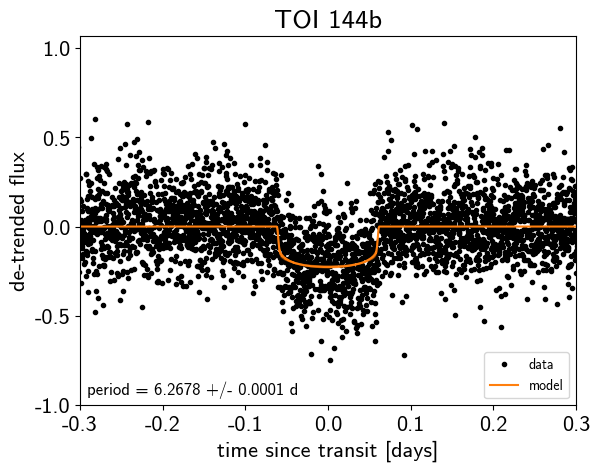

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

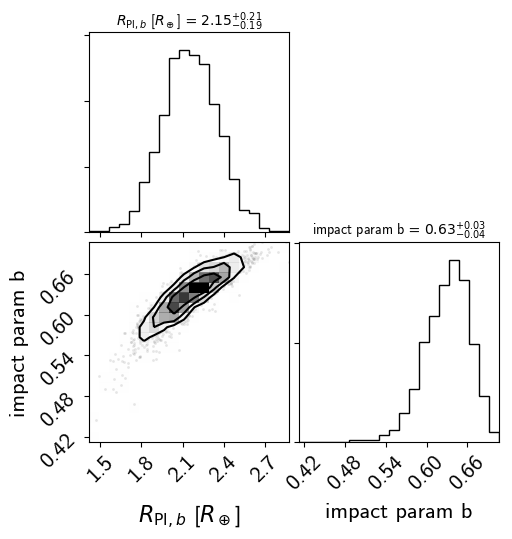

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

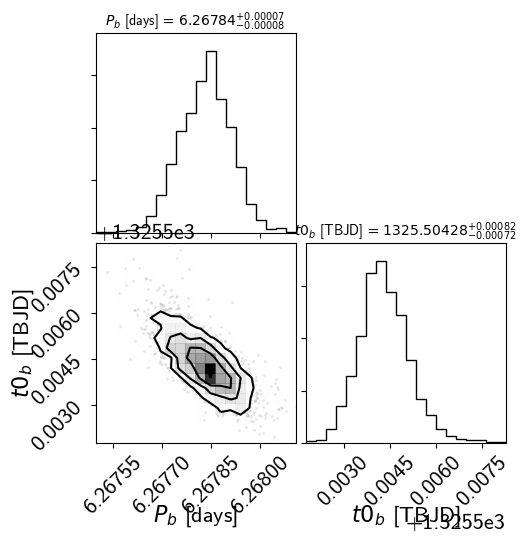

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

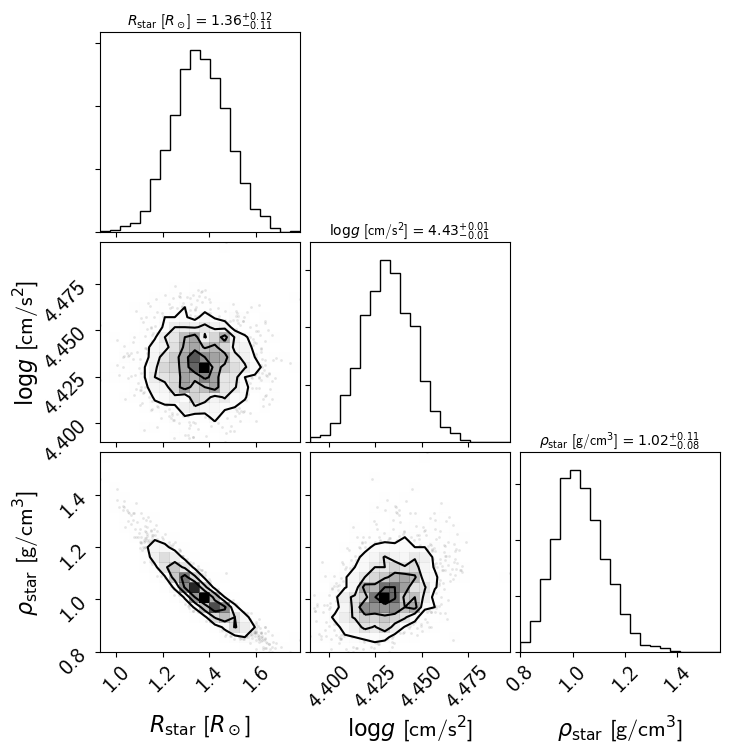

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3